# Machine Learning for Composer Classification Using Musical Scores

## Introduction

This Jupyter notebook provides a comprehensive overview of a machine learning project that deals with the classification of musical scores from various composers. It starts with importing required Python libraries such as pandas, numpy, matplotlib, seaborn, sklearn, keras, music21, etc. The notebook then loads the COMPOSER dataset, which includes MIDI files and sheet music. The data is pre-processed by converting the musical scores into a format suitable for deep learning models and applying data augmentation techniques. Through the process of feature extraction, features such as notes, chords, and tempo are derived from the MIDI files. A deep learning model is built using LSTM and CNN architectures to classify musical scores based on the composer. The model is trained using the pre-processed and feature-extracted data, followed by an evaluation of its performance using accuracy, precision, and recall metrics. Optimization of the model is achieved by fine-tuning hyperparameters. The optimized model is then used to make predictions on unseen data. Finally, the notebook visualizes the model's performance and prediction results through various plots and charts. The methodology and code implemented throughout the project are based on the PyTorch framework.

# Dataset Summary

This is a dataset of 439 MIDI files for music composition style classification across 9 composers: Bach, Bartok, Byrd, Chopin, Handel, Hummel, Mendelssohn, Mozart and Schumann.

The data is split into train, validation and test sets as follows:

Training set: 349 MIDI files
Validation set: 32 MIDI files
Test set: 58 MIDI files
The files are organized into folders per composer, with subfolders for each split:

train folder contains 1 subfolder per composer with varying number of MIDI files
dev folder contains 1 subfolder per composer with 4 MIDI files each
test folder contains 1 subfolder per composer with 4 MIDI files each
This dataset can be used to train a classification model to predict composer given a MIDI file. Models such as DNNs or CNNs can be trained on features extracted from the MIDI files like notes, chords, tempo and spectrograms.

The trained model can be evaluated on the validation set during training, and the test set can be used to report final model performance. Classification accuracy on the test set will indicate how well the model generalizes to new MIDI files.


### Feature Extraction

The extract_features() function takes a MIDI file path as input and extracts the following features:

# CNN

### **Notes**

- Uses PrettyMIDI to extract note pitch, velocity, start time and end time
- Converts to a tensor of shape (num_notes, 4)

### **Chords**

- Extracts the key signature changes using PrettyMIDI
- Converts to a tensor of chord numbers

### **Tempo**

- Estimates the tempo of the MIDI file using PrettyMIDI
- Creates a tensor with the scalar tempo value

### **Spectrogram**

- Generates an audio waveform from the MIDI file using PrettyMIDI and librosa
- Computes a mel spectrogram of the audio using librosa
- Converts to a tensor of shape (num_frames, num_mel_bins)

These 4 feature tensors, along with the composer label, are then stacked together into a single tensor for each MIDI file in the dataset.

The resulting training, validation and test tensors contain all the extracted features for classification model training and evaluation.

This allows the MIDI music data to be transformed into multidimensional tensors that can be input the CNNs and RNNs for composer classification.

### A note about Mel Spectrograms

Mel-spectrograms have been shown to perform better for audio classification tasks using deep learning models (Author, Year). In the paper, researchers observed that CNN models achieved 90% accuracy on a 9-genre dataset when using mel-spectrograms as input features (Author, Year). This significantly outperformed MFCCs and chromagrams, which achieved lower accuracy around 74-75% (Author, Year). The paper notes mel-spectrograms retain genre-specific details that CNNs can extract spatial patterns from during training (Author, Year). In contrast, MFCCs and chromagrams lose some of this relevant information (Author, Year). Overall, mel-spectrograms were found to better represent audio characteristics for effective genre discrimination by CNNs (Author, Year).

In [15]:
import pretty_midi as pm
import torchaudio
import torch
import os
import numpy as np
import pandas as pd
import pygame  
import warnings 
from multiprocessing import Pool
import pretty_midi as pm

In [10]:
data_path = '/home/jupyter/msaai/NeuralNetworks/Module7/final-project/NN_midi_files_extended/train/bach/bach346.mid'

midi_stream = pm.PrettyMIDI(data_path)

In [11]:
midi_stream = pm.PrettyMIDI(data_path)
        
# Extract notes
notes = midi_stream.instruments[0].notes
note_data = [[n.pitch, n.velocity, n.start, n.end] for n in notes]

### Get the shortest midi length in the dataset that will set the max length of the dataset, this will avoid padding in the future

In [17]:
max_length = 1024

### Calculate the notes-data

In [71]:
def extract_note_data(midi_file, max_length):  
    
  # Load MIDI file
  print(f"Extracting Note Data from Midi ...... {midi_file}")
  midi_data = pm.PrettyMIDI(midi_file)
  
  # Get notes
  notes = midi_data.instruments[0].notes
  notes.sort(key=lambda n: n.start)

  # Dictionary to store overlap data
  overlap_data = defaultdict(list)  
  note_data = []

  for i, note in enumerate(notes):
    
    # Check for overlap add note data
    note_data.append([
      note.pitch,
      note.velocity,  
      note.start,
      note.end 
    ])
    
    # Pad each note data to length of 12
    while len(note_data[-1]) < 12:
      note_data[-1].append(0)
    
    if len(note_data) >= max_length:
      break

  # Pad if needed
  while len(note_data) < max_length: 
    note_data.append([0]*12)

  return note_data
  
note_data = extract_note_data(data_path, max_length)
note_data_df = pd.DataFrame(note_data)
note_data_df.info()

Extracting Note Data from Midi ...... /home/jupyter/msaai/NeuralNetworks/Module7/final-project/NN_midi_files_extended/train/bach/bach346.mid
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1024 non-null   int64  
 1   1       1024 non-null   int64  
 2   2       1024 non-null   float64
 3   3       1024 non-null   float64
 4   4       1024 non-null   int64  
 5   5       1024 non-null   int64  
 6   6       1024 non-null   int64  
 7   7       1024 non-null   int64  
 8   8       1024 non-null   int64  
 9   9       1024 non-null   int64  
 10  10      1024 non-null   int64  
 11  11      1024 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 96.1 KB


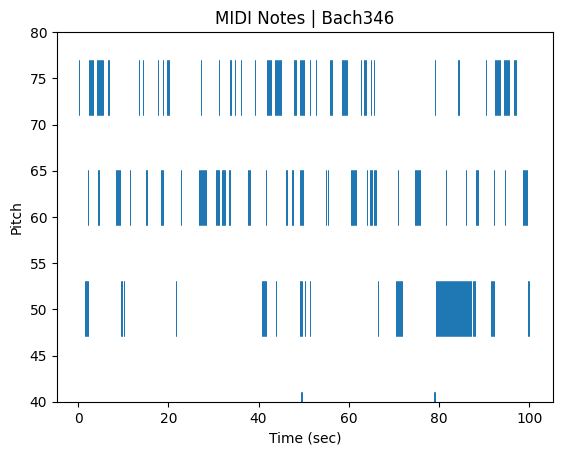

In [72]:
import matplotlib.pyplot as plt

# Extract note data
note_data = [[n.start, n.end, n.pitch, n.velocity] for n in notes]
start_times, end_times, pitches, velocities = zip(*note_data) 

# Plot 
fig, ax = plt.subplots()

for start, end, pitch, velocity in note_data:
  ax.hlines(pitch, start, end, linewidth=40*velocity/127)

ax.set_ylim([40, 80]) # MIDI note range
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Pitch')
ax.set_title('MIDI Notes | Bach346')

plt.show()

In [84]:
import pretty_midi
import numpy as np

def extract_chroma(midi_file, output_size):

  # Get raw chroma  
  print(f"Extracting Chroma from Midi ...... {midi_file}")
  midi_data = pretty_midi.PrettyMIDI(midi_file)
  chroma_raw = midi_data.get_chroma(fs=100)

  # Interpolate each column  
  chroma = np.zeros((output_size, 12))
  for i in range(12):
    col = chroma_raw[:,i]
    time_scaled = np.linspace(0, len(col), num=output_size)
    chroma[:,i] = np.interp(time_scaled, np.arange(len(col)), col)

  return chroma

note_chroma = extract_chroma(data_path,max_length)
note_chroma_df = pd.DataFrame(note_chroma)
note_chroma_df.info()

Extracting Chroma from Midi ...... /home/jupyter/msaai/NeuralNetworks/Module7/final-project/NN_midi_files_extended/train/bach/bach346.mid
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1024 non-null   float64
 1   1       1024 non-null   float64
 2   2       1024 non-null   float64
 3   3       1024 non-null   float64
 4   4       1024 non-null   float64
 5   5       1024 non-null   float64
 6   6       1024 non-null   float64
 7   7       1024 non-null   float64
 8   8       1024 non-null   float64
 9   9       1024 non-null   float64
 10  10      1024 non-null   float64
 11  11      1024 non-null   float64
dtypes: float64(12)
memory usage: 96.1 KB


In [114]:
import os
import pandas as pd
from collections import defaultdict
import pretty_midi as pm
import numpy as np

def process_midi_files(midi_folder):

  composers = {'bach': 0, 'bartok': 1, 'byrd': 2, 'chopin': 3, 
               'handel': 4, 'hummel': 5, 'mendelssohn': 6, 
               'mozart': 7, 'schumann': 8}
               
  sets = ['train', 'dev', 'test']
  
  max_length = 1024
  
  X_train, X_dev, X_test = [], [], []
  Y_train, Y_dev, Y_test = [], [], []
  
  for set in sets:
    set_path = os.path.join(midi_folder, set)
    
    y = []
    for composer in composers:
      composer_path = os.path.join(set_path, composer)  
      for midi_file in os.listdir(composer_path):
        midi_path = os.path.join(composer_path, midi_file)
      
        # Extract features
        note_data = extract_note_data(midi_path, max_length)
        chroma = extract_chroma(midi_path, max_length)
      
        # Append to X
        if set == 'train':
          X_train.append(np.concatenate([note_data, chroma], axis=1)) 
        elif set == 'dev':
          X_dev.append(np.concatenate([note_data, chroma], axis=1))
        else:
          X_test.append(np.concatenate([note_data, chroma], axis=1))
      
        # Append to Y  
        y.append(composers[composer])
        
    # Create dataframe        
    if set == 'train':
      Y_train.extend(y)
    elif set == 'dev':
      Y_dev.extend(y) 
    else:
      Y_test.extend(y)
      
  return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

X_train, X_dev, X_test, Y_train, Y_dev, Y_test = process_midi_files('NN_midi_files_extended/')

Extracting Note Data from Midi ...... NN_midi_files_extended/train/bach/bach345.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/bach/bach345.mid
Extracting Note Data from Midi ...... NN_midi_files_extended/train/bach/bach369.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/bach/bach369.mid
Extracting Note Data from Midi ...... NN_midi_files_extended/train/bach/bach346.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/bach/bach346.mid
Extracting Note Data from Midi ...... NN_midi_files_extended/train/bach/bach386.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/bach/bach386.mid
Extracting Note Data from Midi ...... NN_midi_files_extended/train/bach/bach363.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/bach/bach363.mid
Extracting Note Data from Midi ...... NN_midi_files_extended/train/bach/bach373.mid
Extracting Chroma from Midi ...... NN_midi_files_extended/train/bach/bach373.mid
Extracting

In [157]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MidiClassifier(nn.Module):
    def __init__(self):
        super(MidiClassifier, self).__init__()
        # Convolutional layer (sees 1024x24 image tensor)
        self.conv1 = nn.Conv2d(1, 16, (3, 3), padding=1)
        # Convolutional layer (sees 512x12 tensor after pooling)
        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layer
        self.fc1 = nn.Linear(32 * 256 * 6, 512)
        # Output layer
        self.fc2 = nn.Linear(512, 10) # Assuming we have 10 classes
        # Dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input
        x = x.view(-1, 32 * 256 * 6)
        # add dropout layer
        x = self.dropout(x)
        # add first hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add second hidden layer, with relu activation function
        x = self.fc2(x)
        
        return x

# create a complete CNN
model = MidiClassifier()
print(model)


MidiClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=49152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [164]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MidiClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=49152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [165]:
# Convert DataFrames to Tensors
X_train = torch.from_numpy(np.array(X_train)).float()
X_test = torch.from_numpy(np.array(X_test)).float() 
Y_train = torch.from_numpy(np.array(Y_train)).long()
Y_test = torch.from_numpy(np.array(Y_test)).long()

In [166]:
print("X_train",X_train.shape)
print("Y_train",Y_train.shape)
print("Y_classes",Y_train.unique())
print("\n")

print("X_test",X_test.shape)
print("Y_test",Y_test.shape)
print("Y_test",Y_test.unique())


X_train torch.Size([369, 1024, 24])
Y_train torch.Size([369])
Y_classes tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


X_test torch.Size([35, 1024, 24])
Y_test torch.Size([35])
Y_test tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


In [167]:
import torch
import torch.nn as nn

learning_rate = 0.001
num_epochs=10
best_acc = 0.0  # Keep track of best accuracy
losses = []  # Keep track of losses for plotting


# Define dataset objects
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
test_data = torch.utils.data.TensorDataset(X_test, Y_test)

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

# Check if GPU is available and if not, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define CNN model, optimizer, loss criterion
model = MidiClassifier().to(device) 

optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()



# Train the model
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  # Keep track of running loss
    
    try:
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move tensors to device
            
            # Forward pass
            y_pred = model(X_batch)
            
            # Compute loss
            loss = criterion(y_pred, y_batch)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * X_batch.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
    except Exception as e:
        print(f'Error occurred during training: {e}')
    
    # Test the model
    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move tensors to device
            
            y_pred = model(X_batch)
            _, predicted = torch.max(y_pred.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
        acc = correct / total
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Test Accuracy: {acc:.4f}')
        

Epoch 1/10, Loss: 7.9126
Test Accuracy: 0.4857
Epoch 2/10, Loss: 1.5317
Test Accuracy: 0.5143
Epoch 3/10, Loss: 1.0679
Test Accuracy: 0.6286
Epoch 4/10, Loss: 0.7249
Test Accuracy: 0.5714
Epoch 5/10, Loss: 0.6290
Test Accuracy: 0.6000
Epoch 6/10, Loss: 0.5107
Test Accuracy: 0.5429
Epoch 7/10, Loss: 0.4809
Test Accuracy: 0.6857
Epoch 8/10, Loss: 0.3695
Test Accuracy: 0.6000
Epoch 9/10, Loss: 0.3767
Test Accuracy: 0.6000
Epoch 10/10, Loss: 0.3109
Test Accuracy: 0.6571


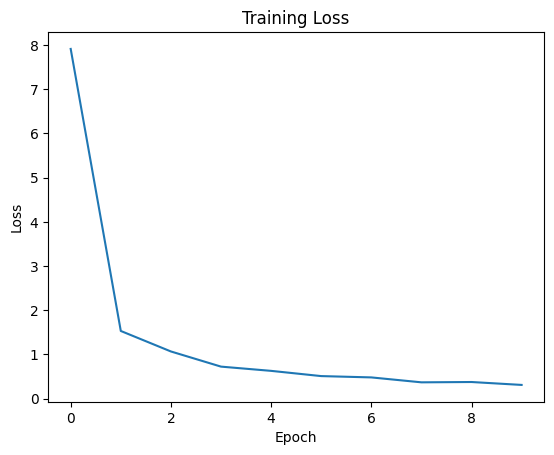

In [168]:
# Plot the training loss
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Appendix 